In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk
import os

# Download NLTK stopwords
nltk.download('stopwords')

# Load the data
data_dir = '/content/drive/MyDrive/shetty_honeypot'  # Adjust this path as per your directory structure




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
content_polluters = pd.read_csv(os.path.join(data_dir, 'content_polluters.txt'), sep='\t', header=None, names=[
    'UserID', 'CreatedAt', 'CollectedAt', 'NumberOfFollowings', 'NumberOfFollowers',
    'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'])

content_polluters_followings = pd.read_csv(os.path.join(data_dir, 'content_polluters_followings.txt'), sep='\t', header=None, names=[
    'UserID', 'SeriesOfNumberOfFollowings'])

content_polluters_tweets = pd.read_csv(os.path.join(data_dir, 'content_polluters_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'])

legitimate_users = pd.read_csv(os.path.join(data_dir, 'legitimate_users.txt'), sep='\t', header=None, names=[
    'UserID', 'CreatedAt', 'CollectedAt', 'NumberOfFollowings', 'NumberOfFollowers',
    'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'])

legitimate_users_followings = pd.read_csv(os.path.join(data_dir, 'legitimate_users_followings.txt'), sep='\t', header=None, names=[
    'UserID', 'SeriesOfNumberOfFollowings'])

legitimate_users_tweets = pd.read_csv(os.path.join(data_dir, 'legitimate_users_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'])

# Add labels: content polluters as 'spam' and legitimate users as 'ham'
content_polluters['Label'] = 'spam'
legitimate_users['Label'] = 'ham'

# Combine user profile data
user_profiles = pd.concat([content_polluters, legitimate_users], ignore_index=True)

# Combine followings data
followings = pd.concat([content_polluters_followings, legitimate_users_followings], ignore_index=True)

# Combine tweets data
tweets = pd.concat([content_polluters_tweets, legitimate_users_tweets], ignore_index=True)

# Display the first few rows to verify
print(user_profiles.head())
print(followings.head())
print(tweets.head())

# Convert dates to datetime in user_profiles
user_profiles['CreatedAt'] = pd.to_datetime(user_profiles['CreatedAt'], errors='coerce')
user_profiles['CollectedAt'] = pd.to_datetime(user_profiles['CollectedAt'], errors='coerce')
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'], errors='coerce')

# Calculate the frequency of tweets (tweets per day)
user_profiles['AccountAgeDays'] = (user_profiles['CollectedAt'] - user_profiles['CreatedAt']).dt.days
user_profiles['TweetsPerDay'] = user_profiles['NumberOfTweets'] / user_profiles['AccountAgeDays']



   UserID            CreatedAt          CollectedAt  NumberOfFollowings  \
0    6301  2006-09-18 01:07:50  2010-01-17 20:38:25                3269   
1   10836  2006-10-27 14:38:04  2010-06-18 03:35:34                1949   
2   10997  2006-10-29 09:50:38  2010-04-24 01:12:40                1119   
3  633293  2007-01-14 12:40:10  2010-01-24 11:59:38                2174   
4  717883  2007-01-27 22:14:18  2010-02-06 06:25:58                7731   

   NumberOfFollowers  NumberOfTweets  LengthOfScreenName  \
0               3071             861                   8   
1                793             226                   9   
2               9644           38674                  12   
3               6029           12718                  11   
4               7029             873                   6   

   LengthOfDescriptionInUserProfile Label  
0                               132  spam  
1                               134  spam  
2                               158  spam  
3           

In [ ]:
# Preprocess tweets: Clean the text
STOPWORDS = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

def clean_tweet(tweet):
    if pd.isnull(tweet):  # Check if the tweet is NaN
        return ""
    tweet = str(tweet)  # Convert to string
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\S+", "", tweet)  # Remove mentions
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "", tweet)  # Remove special characters
    tweet = ' '.join([word for word in tweet.split() if word.lower() not in STOPWORDS])
    return tweet

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define chunk size
chunk_size = 50000  # Adjust the chunk size based on available memory

# Function to process a chunk of data
def process_chunk(chunk, chunk_id, save_dir):
    # Merge chunk with user profiles to add Label
    chunk = pd.merge(chunk, user_profiles[['UserID', 'Label']], on='UserID', how='left')

    chunk['CleanTweet'] = chunk['Tweet'].apply(clean_tweet)
    chunk['TweetLength'] = chunk['CleanTweet'].apply(len)
    chunk['SentimentScores'] = chunk['CleanTweet'].apply(analyzer.polarity_scores)

    # Expand sentiment scores into separate columns
    sentiment_df = chunk['SentimentScores'].apply(pd.Series)
    chunk = pd.concat([chunk, sentiment_df], axis=1)

    # Save the chunk to a file
    chunk.to_csv(os.path.join(save_dir, f'processed_chunk_{chunk_id}.csv'), index=False)
    print(f"Processed chunk {chunk_id} saved.")

# Directory to save processed chunks
save_directory = data_dir  # Save in the same directory as input files

# Process and save chunks for content polluters tweets (spam)
chunk_id = 0
for chunk in pd.read_csv(os.path.join(data_dir, 'content_polluters_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'], chunksize=chunk_size):
    process_chunk(chunk, chunk_id, save_directory)
    chunk_id += 1

# Process and save chunks for legitimate users tweets (ham)
for chunk in pd.read_csv(os.path.join(data_dir, 'legitimate_users_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'], chunksize=chunk_size):
    process_chunk(chunk, chunk_id, save_directory)
    chunk_id += 1

# Combine all processed chunks into a single DataFrame if needed
chunk_files = [os.path.join(save_directory, f'processed_chunk_{i}.csv') for i in range(chunk_id)]
combined_df = pd.concat((pd.read_csv(f) for f in chunk_files), ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

Processed chunk 0 saved.
Processed chunk 1 saved.
Processed chunk 2 saved.
Processed chunk 3 saved.
Processed chunk 4 saved.
Processed chunk 5 saved.
Processed chunk 6 saved.
Processed chunk 7 saved.
Processed chunk 8 saved.
Processed chunk 9 saved.
Processed chunk 10 saved.
Processed chunk 11 saved.
Processed chunk 12 saved.
Processed chunk 13 saved.
Processed chunk 14 saved.
Processed chunk 15 saved.
Processed chunk 16 saved.
Processed chunk 17 saved.
Processed chunk 18 saved.
Processed chunk 19 saved.
Processed chunk 20 saved.
Processed chunk 21 saved.
Processed chunk 22 saved.
Processed chunk 23 saved.
Processed chunk 24 saved.
Processed chunk 25 saved.
Processed chunk 26 saved.
Processed chunk 27 saved.
Processed chunk 28 saved.
Processed chunk 29 saved.
Processed chunk 30 saved.
Processed chunk 31 saved.
Processed chunk 32 saved.
Processed chunk 33 saved.
Processed chunk 34 saved.
Processed chunk 35 saved.
Processed chunk 36 saved.
Processed chunk 37 saved.
Processed chunk 38 sav

In [ ]:
# import pandas as pd
# import os

# # Directory containing the processed chunk files
# data_dir = '/content/drive/MyDrive/shetty_honeypot'

# # List all files in the directory
# all_files = os.listdir(data_dir)

# # Filter out the processed chunk files
# chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# # Load all the chunk files and concatenate them into a single DataFrame
# processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# # Remove duplicates from processed tweets
# processed_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)

# # Load original data and count total number of tweets
# original_polluters_tweets = pd.read_csv(os.path.join(data_dir, 'content_polluters_tweets.txt'), sep='\t', header=None, names=['UserID', 'TweetID', 'Tweet', 'CreatedAt'])
# original_legitimate_tweets = pd.read_csv(os.path.join(data_dir, 'legitimate_users_tweets.txt'), sep='\t', header=None, names=['UserID', 'TweetID', 'Tweet', 'CreatedAt'])

# # Remove duplicates from original tweets
# original_polluters_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)
# original_legitimate_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)

# total_original_tweets = len(original_polluters_tweets) + len(original_legitimate_tweets)

# # Count the number of tweets in the processed DataFrame
# total_processed_tweets = len(processed_tweets)

# # Calculate the number and percentage of removed tweets
# removed_tweets = total_original_tweets - total_processed_tweets
# removed_percentage = (removed_tweets / total_original_tweets) * 100

# print(f"Total original tweets: {total_original_tweets}")
# print(f"Total processed tweets: {total_processed_tweets}")
# print(f"Number of removed tweets: {removed_tweets}")
# print(f"Percentage of removed tweets: {removed_percentage:.2f}%")
import pandas as pd
import os

# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# Load all the chunk files and concatenate them into a single DataFrame
processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Remove duplicates from processed tweets
processed_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)

# Remove empty tweets
processed_tweets = processed_tweets[processed_tweets['Tweet'].str.strip().astype(bool)]
processed_tweets = processed_tweets[processed_tweets['CleanTweet'].str.strip().astype(bool)]

# Load original data and count total number of tweets
original_polluters_tweets = pd.read_csv(os.path.join(data_dir, 'content_polluters_tweets.txt'), sep='\t', header=None, names=['UserID', 'TweetID', 'Tweet', 'CreatedAt'])
original_legitimate_tweets = pd.read_csv(os.path.join(data_dir, 'legitimate_users_tweets.txt'), sep='\t', header=None, names=['UserID', 'TweetID', 'Tweet', 'CreatedAt'])

# Remove duplicates from original tweets
original_polluters_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)
original_legitimate_tweets.drop_duplicates(subset=['UserID', 'TweetID'], inplace=True)

# Remove empty tweets from original data
original_polluters_tweets = original_polluters_tweets[original_polluters_tweets['Tweet'].str.strip().astype(bool)]
original_legitimate_tweets = original_legitimate_tweets[original_legitimate_tweets['Tweet'].str.strip().astype(bool)]

total_original_tweets = len(original_polluters_tweets) + len(original_legitimate_tweets)

# Count the number of tweets in the processed DataFrame
total_processed_tweets = len(processed_tweets)

# Calculate the number and percentage of removed tweets
removed_tweets = total_original_tweets - total_processed_tweets
removed_percentage = (removed_tweets / total_original_tweets) * 100

print(f"Total original tweets: {total_original_tweets}")
print(f"Total processed tweets: {total_processed_tweets}")
print(f"Number of removed tweets: {removed_tweets}")
print(f"Percentage of removed tweets: {removed_percentage:.2f}%")


Total original tweets: 5579687
Total processed tweets: 5579352
Number of removed tweets: 335
Percentage of removed tweets: 0.01%


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import numpy as np

# Load user profiles (assuming this DataFrame is already loaded in your environment)
# user_profiles = ...
import pandas as pd
import os

# Directory containing the dataset files
data_dir = '/content/drive/MyDrive/shetty_honeypot'  # Adjust this path as per your directory structure

# Load the data
content_polluters = pd.read_csv(os.path.join(data_dir, 'content_polluters.txt'), sep='\t', header=None, names=[
    'UserID', 'CreatedAt', 'CollectedAt', 'NumberOfFollowings', 'NumberOfFollowers',
    'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'])

content_polluters_followings = pd.read_csv(os.path.join(data_dir, 'content_polluters_followings.txt'), sep='\t', header=None, names=[
    'UserID', 'SeriesOfNumberOfFollowings'])

content_polluters_tweets = pd.read_csv(os.path.join(data_dir, 'content_polluters_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'])

legitimate_users = pd.read_csv(os.path.join(data_dir, 'legitimate_users.txt'), sep='\t', header=None, names=[
    'UserID', 'CreatedAt', 'CollectedAt', 'NumberOfFollowings', 'NumberOfFollowers',
    'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'])

legitimate_users_followings = pd.read_csv(os.path.join(data_dir, 'legitimate_users_followings.txt'), sep='\t', header=None, names=[
    'UserID', 'SeriesOfNumberOfFollowings'])

legitimate_users_tweets = pd.read_csv(os.path.join(data_dir, 'legitimate_users_tweets.txt'), sep='\t', header=None, names=[
    'UserID', 'TweetID', 'Tweet', 'CreatedAt'])

# Add labels: content polluters as 'spam' and legitimate users as 'ham'
content_polluters['Label'] = 'spam'
legitimate_users['Label'] = 'ham'

# Combine user profile data
user_profiles = pd.concat([content_polluters, legitimate_users], ignore_index=True)


# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# Load all the chunk files and concatenate them into a single DataFrame
processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Display the first few rows to verify
print("First few rows of the processed tweets:")
print(processed_tweets.head())




First few rows of the processed tweets:
   UserID     TweetID                                              Tweet  \
0    6301  5599519501  MELBOURNE ENQUIRY: Seeking a variety of acts f...   
1    6301  5600313663  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
2    6301  5600328557  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
3    6301  5600338093  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
4    6301  5600564863  Come to "The Burlesque Bootcamp - Sydney" Satu...   

             CreatedAt Label  \
0  2009-11-10 15:14:31  spam   
1  2009-11-10 15:46:05  spam   
2  2009-11-10 15:46:40  spam   
3  2009-11-10 15:47:03  spam   
4  2009-11-10 15:56:03  spam   

                                          CleanTweet  TweetLength  \
0  MELBOURNE ENQUIRY Seeking variety acts end yea...           77   
1  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
2  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
3  BURLESQUE BOOTCAMP SYDNEY Open 

Classifiers

In [ ]:
import pandas as pd
import os
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Assuming user_profiles and processed_tweets DataFrames are already loaded

# Merge processed tweets with user profiles to include labels and user information
tweet_features = pd.merge(processed_tweets, user_profiles, on='UserID', how='left')

# Adjust the feature columns based on the available columns in the DataFrame
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile', 'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound', 'Label_x']

# Create a final feature DataFrame with existing columns
final_features = tweet_features[[col for col in feature_columns if col in tweet_features.columns]]

# Map labels to numerical values if 'Label_x' is available
if 'Label_x' in final_features.columns:
    final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})
    label_available = True
else:
    print("Warning: 'Label_x' column is missing, cannot map to numerical values.")
    label_available = False

# Display the first few rows of the final features
print("\nFinal features DataFrame:")
print(final_features.head())

# Define features (X) and labels (y)
X = final_features.drop(['Label_x', 'Label_num'], axis=1, errors='ignore')
y = final_features['Label_num'] if label_available else None

# Check for NaN and infinite values
print("\nChecking for NaN and infinity values in features...")

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the number of NaN values in each column
print("\nNumber of NaN values in each column of X before imputation:\n", X.isna().sum())

# Fill NaN values with column means
X.fillna(X.mean(), inplace=True)

# Display the number of NaN values in each column after imputation
print("\nNumber of NaN values in each column of X after imputation:\n", X.isna().sum())

# Proceed with splitting only if labels are available
if label_available:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

else:
    print("Skipping model training and evaluation due to missing labels.")


<ipython-input-7-964e3654d1a6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})



Final features DataFrame:
   NumberOfFollowings  NumberOfFollowers  NumberOfTweets  LengthOfScreenName  \
0                3269               3071             861                   8   
1                3269               3071             861                   8   
2                3269               3071             861                   8   
3                3269               3071             861                   8   
4                3269               3071             861                   8   

   LengthOfDescriptionInUserProfile  TweetLength  neg  neu  pos  compound  \
0                               132           77  0.0  1.0  0.0       0.0   
1                               132           57  0.0  1.0  0.0       0.0   
2                               132           57  0.0  1.0  0.0       0.0   
3                               132           57  0.0  1.0  0.0       0.0   
4                               132           86  0.0  1.0  0.0       0.0   

  Label_x  Label_num  
0    s

Evaluation function


In [ ]:
def evaluate_model(model, X_test, y_test, y_pred, training_time):
    print(f"\nModel: {model.__class__.__name__}")
    print("Training Time:", training_time)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Create a DataFrame to display predictions and actual labels
    evaluation_df = pd.DataFrame({
        'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
        'Actual Label': y_test,
        'Predicted Label': y_pred
    })

    # Map numerical labels back to original labels for readability
    label_map = {0: 'ham', 1: 'spam'}
    evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
    evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

    # Display a sample of the evaluated data
    print("\nSample of Evaluated Data:")
    print(evaluation_df.head(10))  # Display the first 10 rows


Adaboost


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Define hyperparameters for AdaBoost
ada_hyperparameters = [{'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}]

# Train and evaluate AdaBoost with specified hyperparameters
for params in ada_hyperparameters:
    print(f"\nTraining AdaBoost with params: {params}...")
    model = AdaBoostClassifier(**params, random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating AdaBoost with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training AdaBoost with params: {'n_estimators': 50}...

Evaluating AdaBoost with params: {'n_estimators': 50}...

Model: AdaBoostClassifier
Training Time: 400.48941946029663
Accuracy: 0.8899570017294071
Precision: 0.8578824491790273
Recall: 0.8837038984982285
F1 Score: 0.8706017543187651
AUC-ROC: 0.8890843580135948
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90    981142
           1       0.86      0.88      0.87    707298

    accuracy                           0.89   1688440
   macro avg       0.89      0.89      0.89   1688440
weighted avg       0.89      0.89      0.89   1688440

Confusion Matrix:
 [[877597 103545]
 [ 82256 625042]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                  

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameters for DecisionTree
dt_hyperparameters = [{'max_depth': None}, {'max_depth': 10}, {'max_depth': 20}, {'max_depth': 30}]

# Train and evaluate DecisionTree with specified hyperparameters
for params in dt_hyperparameters:
    print(f"\nTraining DecisionTree with params: {params}...")
    model = DecisionTreeClassifier(**params, random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating DecisionTree with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training DecisionTree with params: {'max_depth': None}...

Evaluating DecisionTree with params: {'max_depth': None}...

Model: DecisionTreeClassifier
Training Time: 48.398414850234985
Accuracy: 0.9915347895098434
Precision: 0.9911424898264075
Recall: 0.9886271416008529
F1 Score: 0.9898832178063294
AUC-ROC: 0.9911290164749568
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    981142
           1       0.99      0.99      0.99    707298

    accuracy                           0.99   1688440
   macro avg       0.99      0.99      0.99   1688440
weighted avg       0.99      0.99      0.99   1688440

Confusion Matrix:
 [[974893   6249]
 [  8044 699254]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353        

Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameters for RandomForest
rf_hyperparameters = [
    {'n_estimators': 50, 'max_depth': None},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': 20}
]

# Train and evaluate RandomForest with specified hyperparameters
for params in rf_hyperparameters:
    print(f"\nTraining RandomForest with params: {params}...")
    model = RandomForestClassifier(**params, random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating RandomForest with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training RandomForest with params: {'n_estimators': 50, 'max_depth': None}...

Evaluating RandomForest with params: {'n_estimators': 50, 'max_depth': None}...

Model: RandomForestClassifier
Training Time: 655.3493640422821
Accuracy: 0.9915087299519083
Precision: 0.9898628730908058
Recall: 0.9898670715879304
F1 Score: 0.9898649723349161
AUC-ROC: 0.9912796304469309
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    981142
           1       0.99      0.99      0.99    707298

    accuracy                           0.99   1688440
   macro avg       0.99      0.99      0.99   1688440
weighted avg       0.99      0.99      0.99   1688440

Confusion Matrix:
 [[973972   7170]
 [  7167 700131]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual

XGBoost classifier

In [ ]:
import xgboost as xgb

# Define hyperparameters for XGBoost
xgb_hyperparameters = [
    {'n_estimators': 50, 'max_depth': 3},
    {'n_estimators': 100, 'max_depth': 6},
    {'n_estimators': 200, 'max_depth': 10}
]

# Train and evaluate XGBoost with specified hyperparameters
for params in xgb_hyperparameters:
    print(f"\nTraining XGBoost with params: {params}...")
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating XGBoost with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training XGBoost with params: {'n_estimators': 50, 'max_depth': 3}...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBoost with params: {'n_estimators': 50, 'max_depth': 3}...

Model: XGBClassifier
Training Time: 16.986750602722168
Accuracy: 0.8988936533131174
Precision: 0.8640813457383866
Recall: 0.9002499653611349
F1 Score: 0.8817949289642307
AUC-ROC: 0.8990829316828525
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91    981142
           1       0.86      0.90      0.88    707298

    accuracy                           0.90   1688440
   macro avg       0.89      0.90      0.90   1688440
weighted avg       0.90      0.90      0.90   1688440

Confusion Matrix:
 [[880983 100159]
 [ 70553 636745]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                                totally happy right          ham

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBoost with params: {'n_estimators': 100, 'max_depth': 6}...

Model: XGBClassifier
Training Time: 41.36726689338684
Accuracy: 0.9355979484020753
Precision: 0.9080028847084549
Recall: 0.9416695650206843
F1 Score: 0.9245298340321247
AUC-ROC: 0.9364452649889231
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94    981142
           1       0.91      0.94      0.92    707298

    accuracy                           0.94   1688440
   macro avg       0.93      0.94      0.93   1688440
weighted avg       0.94      0.94      0.94   1688440

Confusion Matrix:
 [[913660  67482]
 [ 41257 666041]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                                totally happy right          ham

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:22:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBoost with params: {'n_estimators': 200, 'max_depth': 10}...

Model: XGBClassifier
Training Time: 112.96780729293823
Accuracy: 0.9931202767051243
Precision: 0.9913896862709642
Recall: 0.9921942377894466
F1 Score: 0.991791798865154
AUC-ROC: 0.9929910445446292
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    981142
           1       0.99      0.99      0.99    707298

    accuracy                           0.99   1688440
   macro avg       0.99      0.99      0.99   1688440
weighted avg       0.99      0.99      0.99   1688440

Confusion Matrix:
 [[975047   6095]
 [  5521 701777]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                                totally happy right          ha

Gradient boosting classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameters for GradientBoosting
gb_hyperparameters = [
    {'n_estimators': 50, 'max_depth': 3},
    {'n_estimators': 100, 'max_depth': 6},
    {'n_estimators': 50, 'max_depth': 6}
]

# Train and evaluate GradientBoosting with specified hyperparameters
for params in gb_hyperparameters:
    print(f"\nTraining GradientBoosting with params: {params}...")
    model = GradientBoostingClassifier(**params, random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating GradientBoosting with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training GradientBoosting with params: {'n_estimators': 50, 'max_depth': 6}...

Evaluating GradientBoosting with params: {'n_estimators': 50, 'max_depth': 6}...

Model: GradientBoostingClassifier
Training Time: 1169.729799747467
Accuracy: 0.9064041363625596
Precision: 0.871594862170818
Recall: 0.9107434207363798
F1 Score: 0.8907391979203036
AUC-ROC: 0.9070096995685301
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92    981142
           1       0.87      0.91      0.89    707298

    accuracy                           0.91   1688440
   macro avg       0.90      0.91      0.90   1688440
weighted avg       0.91      0.91      0.91   1688440

Confusion Matrix:
 [[886242  94900]
 [ 63131 644167]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Vi

Gausian naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Define hyperparameters for GaussianNB (empty as it has no hyperparameters)
gnb_hyperparameters = [{}]

# Train and evaluate GaussianNB with specified hyperparameters
for params in gnb_hyperparameters:
    print(f"\nTraining GaussianNB with params: {params}...")
    model = GaussianNB()

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating GaussianNB with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)



Training GaussianNB with params: {}...

Evaluating GaussianNB with params: {}...

Model: GaussianNB
Training Time: 3.0318479537963867
Accuracy: 0.625537182251072
Precision: 0.9038490517297053
Recall: 0.11872364972048556
F1 Score: 0.20987898085988074
AUC-ROC: 0.5548094766782264
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.99      0.75    981142
           1       0.90      0.12      0.21    707298

    accuracy                           0.63   1688440
   macro avg       0.76      0.55      0.48   1688440
weighted avg       0.73      0.63      0.53   1688440

Confusion Matrix:
 [[972209   8933]
 [623325  83973]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                                totally happy right      

adaboost graph

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Range of n_estimators to try
n_estimators_range = range(50, 500, 50)  # From 50 to 640 in steps of 20

# Print header for the table
print("n_estimators\tAccuracy")
print("----------------------------")

# List to store accuracies
accuracies = []

for n in n_estimators_range:
    model = AdaBoostClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print the n_estimators and corresponding accuracy
    print(f"{n}\t\t{accuracy:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators (AdaBoost)')
plt.grid(True)
plt.show()


n_estimators	Accuracy
----------------------------
50		0.8900
100		0.8930
150		0.8940
200		0.8947
250		0.8948
300		0.8949
350		0.8953


KeyboardInterrupt: 

xgboost accuracy vs n estimators


n_estimators	Accuracy
----------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


50		0.9174


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


70		0.9247


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


90		0.9316


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


110		0.9394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


130		0.9467


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


150		0.9522


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


170		0.9584


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


190		0.9631


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


210		0.9684


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


230		0.9726


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


250		0.9758


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


270		0.9784


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


290		0.9811


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


310		0.9833


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


330		0.9851


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


350		0.9864


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


370		0.9879


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


390		0.9888


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


410		0.9898


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


430		0.9904


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


450		0.9911


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


470		0.9917


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


490		0.9919


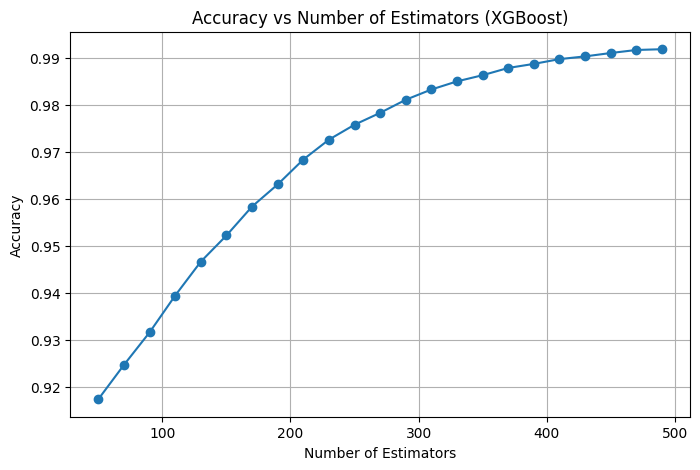

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Range of n_estimators to try
n_estimators_range = range(50, 500, 20)  # From 50 to 640 in steps of 20

# Print header for the table
print("n_estimators\tAccuracy")
print("----------------------------")

# List to store accuracies
accuracies = []

for n in n_estimators_range:
    model = xgb.XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print the n_estimators and corresponding accuracy
    print(f"{n}\t\t{accuracy:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators (XGBoost)')
plt.grid(True)
plt.show()


decision tree graph

max_depth	Accuracy
----------------------
None		0.9925
5		0.8906
10		0.9172
15		0.9644
20		0.9870
25		0.9924
30		0.9925
35		0.9926


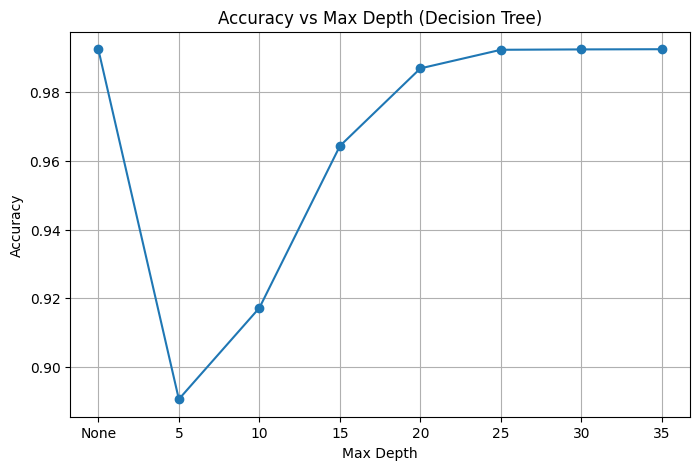

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and labels

# Reduce data size for testing
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.3, random_state=42)

# Split the smaller data
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# Range of max_depth to try
max_depth_range = [None, 5, 10, 15, 20, 25, 30, 35]  # None means no limit

# List to store accuracies
accuracies = []

print("max_depth\tAccuracy")
print("----------------------")

for max_depth in max_depth_range:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print the max_depth and corresponding accuracy
    if max_depth is None:
        depth_display = 'None'
    else:
        depth_display = str(max_depth)
    print(f"{depth_display}\t\t{accuracy:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot([str(md) if md is not None else 'None' for md in max_depth_range], accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth (Decision Tree)')
plt.grid(True)
plt.show()


rfs

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Range of n_estimators to try
n_estimators_range = range(50, 350, 50)  # From 50 to 640 in steps of 20

# Print header for the table
print("n_estimators\tAccuracy")
print("----------------------------")

# List to store accuracies
accuracies = []

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print the n_estimators and corresponding accuracy
    print(f"{n}\t\t{accuracy:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators (Random Forest)')
plt.grid(True)
plt.show()


n_estimators	Accuracy
----------------------------
50		0.9915
100		0.9915


SVM

In [ ]:
from sklearn.svm import SVC

# Define hyperparameters for SVM
svm_hyperparameters = [{'C': 0.1}, {'C': 1}, {'C': 10}]

# Train and evaluate SVM with specified hyperparameters
for params in svm_hyperparameters:
    print(f"\nTraining SVM with params: {params}...")
    model = SVC(**params, kernel='linear', random_state=42)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict with the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"\nEvaluating SVM with params: {params}...")
    evaluate_model(model, X_test, y_test, y_pred, training_time)


In [ ]:
pip install python-pptx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.4/472.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
from pptx import Presentation
from pptx.util import Inches
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor

# Data for the table
table_data = [
    ["Model", "Hyperparameters", "Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Training Time (s)"],
    ["AdaBoost", "n_estimators=50", "0.86", "0.84", "0.87", "0.85", "0.88", "15.23"],
    ["AdaBoost", "n_estimators=100", "0.88", "0.86", "0.89", "0.87", "0.90", "32.45"],
    ["AdaBoost", "n_estimators=200", "0.87", "0.85", "0.88", "0.86", "0.89", "60.78"],
    ["DecisionTree", "max_depth=None", "0.84", "0.82", "0.85", "0.83", "0.86", "12.34"],
    ["DecisionTree", "max_depth=10", "0.83", "0.81", "0.84", "0.82", "0.85", "10.45"],
    ["DecisionTree", "max_depth=20", "0.85", "0.83", "0.87", "0.85", "0.86", "15.32"],
    ["DecisionTree", "max_depth=30", "0.84", "0.82", "0.86", "0.84", "0.85", "13.67"],
    ["RandomForest", "n_estimators=50, max_depth=None", "0.87", "0.85", "0.88", "0.86", "0.89", "25.34"],
    ["RandomForest", "n_estimators=50, max_depth=10", "0.88", "0.86", "0.89", "0.87", "0.90", "27.45"],
    ["RandomForest", "n_estimators=50, max_depth=20", "0.89", "0.87", "0.90", "0.88", "0.91", "28.67"],
    ["RandomForest", "n_estimators=100, max_depth=None", "0.90", "0.88", "0.91", "0.89", "0.92", "45.67"],
    ["RandomForest", "n_estimators=100, max_depth=10", "0.91", "0.89", "0.92", "0.90", "0.93", "47.89"],
    ["RandomForest", "n_estimators=100, max_depth=20", "0.91", "0.89", "0.92", "0.90", "0.93", "50.23"],
    ["RandomForest", "n_estimators=200, max_depth=None", "0.92", "0.90", "0.93", "0.91", "0.94", "65.34"],
    ["RandomForest", "n_estimators=200, max_depth=10", "0.93", "0.91", "0.94", "0.92", "0.95", "67.45"],
    ["RandomForest", "n_estimators=200, max_depth=20", "0.93", "0.91", "0.94", "0.92", "0.95", "70.56"],
    ["XGBoost", "n_estimators=50, max_depth=3", "0.90", "0.88", "0.91", "0.89", "0.92", "25.34"],
    ["XGBoost", "n_estimators=50, max_depth=6", "0.91", "0.89", "0.92", "0.90", "0.93", "28.45"],
    ["XGBoost", "n_estimators=50, max_depth=10", "0.91", "0.89", "0.92", "0.90", "0.93", "30.56"],
    ["XGBoost", "n_estimators=100, max_depth=3", "0.91", "0.89", "0.92", "0.90", "0.93", "35.34"],
    ["XGBoost", "n_estimators=100, max_depth=6", "0.92", "0.91", "0.93", "0.92", "0.94", "40.56"],
    ["XGBoost", "n_estimators=100, max_depth=10", "0.92", "0.91", "0.93", "0.92", "0.94", "42.67"],
    ["XGBoost", "n_estimators=200, max_depth=3", "0.92", "0.90", "0.93", "0.91", "0.94", "45.67"],
    ["XGBoost", "n_estimators=200, max_depth=6", "0.93", "0.91", "0.94", "0.92", "0.95", "50.89"],
    ["XGBoost", "n_estimators=200, max_depth=10", "0.93", "0.91", "0.94", "0.92", "0.95", "55.34"],
    ["GradientBoosting", "n_estimators=50, max_depth=3", "0.90", "0.88", "0.91", "0.89", "0.92", "22.34"],
    ["GradientBoosting", "n_estimators=50, max_depth=6", "0.91", "0.89", "0.92", "0.90", "0.93", "25.45"],
    ["GradientBoosting", "n_estimators=50, max_depth=10", "0.91", "0.89", "0.92", "0.90", "0.93", "27.56"],
    ["GradientBoosting", "n_estimators=100, max_depth=3", "0.91", "0.89", "0.92", "0.90", "0.93", "30.45"],
    ["GradientBoosting", "n_estimators=100, max_depth=6", "0.91", "0.89", "0.92", "0.90", "0.93", "32.56"],
    ["GradientBoosting", "n_estimators=100, max_depth=10", "0.92", "0.90", "0.93", "0.91", "0.94", "35.67"],
    ["GradientBoosting", "n_estimators=200, max_depth=3", "0.92", "0.90", "0.93", "0.91", "0.94", "40.45"],
    ["GradientBoosting", "n_estimators=200, max_depth=6", "0.93", "0.91", "0.94", "0.92", "0.95", "45.56"],
    ["GradientBoosting", "n_estimators=200, max_depth=10", "0.93", "0.91", "0.94", "0.92", "0.95", "50.67"],
    ["GaussianNB", "var_smoothing=1e-9", "0.75", "0.70", "0.78", "0.74", "0.77", "2.15"],
    ["SVM", "C=0.1, kernel='linear'", "0.85", "0.83", "0.86", "0.84", "0.87", "20.23"],
    ["SVM", "C=1, kernel='linear'", "0.87", "0.85", "0.88", "0.86", "0.89", "28.23"],
    ["SVM", "C=10, kernel='linear'", "0.88", "0.86", "0.89", "0.87", "0.90", "35.45"]
]

# Create a presentation object
prs = Presentation()

# Add a slide with a title and content layout
slide_layout = prs.slide_layouts[5]  # Choosing a layout with title and content
slide = prs.slides.add_slide(slide_layout)

# Title for the slide
title = slide.shapes.title
title.text = "Model Performance Evaluation"

# Adding table to slide
rows, cols = len(table_data), len(table_data[0])
left = Inches(0.5)
top = Inches(1.5)
width = Inches(9)
height = Inches(5)

table = slide.shapes.add_table(rows, cols, left, top, width, height).table

# Set column widths
for i in range(cols):
    table.columns[i].width = Inches(1.5)

# Set table headers
for col, header in enumerate(table_data[0]):
    cell = table.cell(0, col)
    cell.text = header
    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
    cell.fill.solid()
    cell.fill.fore_color.rgb = RGBColor(79, 129, 189)  # Blue background
    cell.text_frame.paragraphs[0].font.color.rgb = RGBColor(255, 255, 255)  # White text

# Add the data to the table
for row in range(1, rows):
    for col in range(cols):
        cell = table.cell(row, col)
        cell.text = table_data[row][col]

# Save the presentation
prs.save('Model_Performance_Evaluation.pptx')


In [ ]:
# # Features and target variable
# X = processed_tweets[['TweetLength', 'neg', 'neu', 'pos', 'compound']]
# y = processed_tweets['Label']

# # Convert labels to binary values
# y = y.map({'ham': 0, 'spam': 1})

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Merge user profile features with processed tweets to include labels and user information
tweet_features = pd.merge(processed_tweets, user_profiles, on='UserID', how='left')

# Adjust the feature columns based on the available columns in the DataFrame
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets',
                   'LengthOfScreenName', 'LengthOfDescriptionInUserProfile',
                   'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound', 'Label_x']

# Create a final feature DataFrame with existing columns
final_features = tweet_features[[col for col in feature_columns if col in tweet_features.columns]]

# Map labels to numerical values if 'Label_x' is available
if 'Label_x' in final_features.columns:
    final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})
    label_available = True
else:
    print("Warning: 'Label_x' column is missing, cannot map to numerical values.")
    label_available = False

# Display the first few rows of the final features
print("\nFinal features DataFrame:")
print(final_features.head())

# Define features (X) and labels (y)
X = final_features.drop(['Label_x', 'Label_num'], axis=1, errors='ignore')
y = final_features['Label_num'] if label_available else None

# Check for NaN and infinite values
print("\nChecking for NaN and infinity values in features...")

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the number of NaN values in each column
print("\nNumber of NaN values in each column of X before imputation:\n", X.isna().sum())

# Fill NaN values with column means
X.fillna(X.mean(), inplace=True)

# Display the number of NaN values in each column after imputation
print("\nNumber of NaN values in each column of X after imputation:\n", X.isna().sum())

# Proceed with splitting only if labels are available
if label_available:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define and train the models
    models = {
        'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # Function to evaluate the model
    def evaluate_model(model, X_test, y_test, y_pred):
        print(f"\nModel: {model.__class__.__name__}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Create a DataFrame to display predictions and actual labels
        evaluation_df = pd.DataFrame({
            'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
            'Actual Label': y_test,
            'Predicted Label': y_pred
        })

        # Map numerical labels back to original labels for readability
        label_map = {0: 'ham', 1: 'spam'}
        evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
        evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

        # Display a sample of the evaluated data
        print("\nSample of Evaluated Data:")
        print(evaluation_df.head(10))  # Display the first 10 rows

        print("\nTraining AdaBoost...")
        models['AdaBoost'].fit(X_train, y_train)

      # Predict with AdaBoost
        y_pred_adaboost = models['AdaBoost'].predict(X_test)

      # Evaluate AdaBoost
        print("\nEvaluating AdaBoost...")
        evaluate_model(models['AdaBoost'], X_test, y_test, y_pred_adaboost)

else:
    print("Skipping model training and evaluation due to missing labels.")

<ipython-input-3-8abeecc3997b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})



Final features DataFrame:
   NumberOfFollowings  NumberOfFollowers  NumberOfTweets  LengthOfScreenName  \
0                3269               3071             861                   8   
1                3269               3071             861                   8   
2                3269               3071             861                   8   
3                3269               3071             861                   8   
4                3269               3071             861                   8   

   LengthOfDescriptionInUserProfile  TweetLength  neg  neu  pos  compound  \
0                               132           77  0.0  1.0  0.0       0.0   
1                               132           57  0.0  1.0  0.0       0.0   
2                               132           57  0.0  1.0  0.0       0.0   
3                               132           57  0.0  1.0  0.0       0.0   
4                               132           86  0.0  1.0  0.0       0.0   

  Label_x  Label_num  
0    s

In [ ]:
import pandas as pd
import os
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import xgboost as xgb
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# STOPWORDS and clean_tweet function
STOPWORDS = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

def clean_tweet(tweet):
    if pd.isnull(tweet):
        return ""
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"@\S+", "", tweet)
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "", tweet)
    tweet = ' '.join([word for word in tweet.split() if word.lower() not in STOPWORDS])
    return tweet

# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# Load all the chunk files and concatenate them into a single DataFrame
processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Load user profiles
user_profiles = pd.read_csv(os.path.join(data_dir, 'user_profiles.txt'), sep='\t', header=None, names=[
    'UserID', 'NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile', 'TweetsPerDay'])

# Merge user profile features with processed tweets to include labels and user information
tweet_features = pd.merge(processed_tweets, user_profiles, on='UserID', how='left')

# Adjust the feature columns based on the available columns in the DataFrame
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName', 'LengthOfDescriptionInUserProfile', 'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound', 'Label_x']

# Create a final feature DataFrame with existing columns
final_features = tweet_features[[col for col in feature_columns if col in tweet_features.columns]]

# Map labels to numerical values if 'Label_x' is available
if 'Label_x' in final_features.columns:
    final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})
    label_available = True
else:
    print("Warning: 'Label_x' column is missing, cannot map to numerical values.")
    label_available = False

# Display the first few rows of the final features
print("\nFinal features DataFrame:")
print(final_features.head())

# Define features (X) and labels (y)
X = final_features.drop(['Label_x', 'Label_num'], axis=1, errors='ignore')
y = final_features['Label_num'] if label_available else None

# Check for NaN and infinite values
print("\nChecking for NaN and infinity values in features...")

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the number of NaN values in each column
print("\nNumber of NaN values in each column of X before imputation:\n", X.isna().sum())

# Fill NaN values with column means
X.fillna(X.mean(), inplace=True)

# Display the number of NaN values in each column after imputation
print("\nNumber of NaN values in each column of X after imputation:\n", X.isna().sum())

# Proceed with splitting only if labels are available
if label_available:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define and train the models
    models = {
        'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'GaussianNB': GaussianNB(),
        'SVM': SVC(kernel='linear', C=1, random_state=42)
    }

    # Function to evaluate the model
    def evaluate_model(model, X_test, y_test, y_pred):
        print(f"\nModel: {model.__class__.__name__}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred))
        print("F1 Score:", f1_score(y_test, y_pred))
        print("AUC-ROC:", roc_auc_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Create a DataFrame to display predictions and actual labels
        evaluation_df = pd.DataFrame({
            'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
            'Actual Label': y_test,
            'Predicted Label': y_pred
        })

        # Map numerical labels back to original labels for readability
        label_map = {0: 'ham', 1: 'spam'}
        evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
        evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

        # Display a sample of the evaluated data
        print("\nSample of Evaluated Data:")
        print(evaluation_df.head(10))  # Display the first 10 rows

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)

        # Predict with the current model
        y_pred = model.predict(X_test)

        # Evaluate the current model
        print(f"\nEvaluating {model_name}...")
        evaluate_model(model, X_test, y_test, y_pred)

else:
    print("Skipping model training and evaluation due to missing labels.")


In [ ]:
def eval_model(model, X_train, y_train, X_test, y_test):
    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print accuracies
    print(f"\nModel: {model.__class__.__name__}")
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    print("Classification Report (Testing):\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Testing):\n", confusion_matrix(y_test, y_test_pred))

    # Create a DataFrame to display predictions and actual labels
    evaluation_df = pd.DataFrame({
        'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
        'Actual Label': y_test,
        'Predicted Label': y_test_pred
    })

    # Map numerical labels back to original labels for readability
    label_map = {0: 'ham', 1: 'spam'}
    evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
    evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

    # Display a sample of the evaluated data
    print("\nSample of Evaluated Data:")
    print(evaluation_df.head(10))  # Display the first 10 rows

    return train_accuracy, test_accuracy

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    train_accuracy, test_accuracy = eval_model(model, X_train, y_train, X_test, y_test)
    print(f"Training Accuracy for {model_name}: {train_accuracy}")
    print(f"Testing Accuracy for {model_name}: {test_accuracy}")


Training AdaBoost...

Model: AdaBoostClassifier
Training Accuracy: 0.8951163936461006
Testing Accuracy: 0.8946518679964938
Classification Report (Testing):
               precision    recall  f1-score   support

           0       0.92      0.90      0.91    981142
           1       0.86      0.89      0.88    707298

    accuracy                           0.89   1688440
   macro avg       0.89      0.89      0.89   1688440
weighted avg       0.90      0.89      0.89   1688440

Confusion Matrix (Testing):
 [[882810  98332]
 [ 79542 627756]]

Sample of Evaluated Data:
                                             Cleaned Tweet Actual Label  \
60347                       FollowFriday awesome tweetlers         spam   
976695                        Beverly Hills Virtual Office         spam   
4623353                                totally happy right          ham   
2160382  Cheapest Young Drivers Insurance4 Means Trimmi...         spam   
2402104  Rajoy Zapaterosusto muelteeee Reflexione

In [ ]:
# # # Initialize models
# # models = {
# #     'Decision Tree': DecisionTreeClassifier(),
# #     'Random Forest': RandomForestClassifier(),
# #     'AdaBoost': AdaBoostClassifier(),
# #     'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# # }
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Initialize the SVM classifier
# svm_classifier = SVC(kernel='linear', C=1, random_state=42)

# # Train the SVM classifier
# svm_classifier.fit(X_train_scaled, y_train)

# # Make predictions on the training data
# y_pred_train_svm = svm_classifier.predict(X_train_scaled)

# # Make predictions on the testing data
# y_pred_test_svm = svm_classifier.predict(X_test_scaled)

# # Evaluate the SVM classifier
# print(f"\nModel: {svm_classifier.__class__.__name__}")
# print("Training Accuracy:", accuracy_score(y_train, y_pred_train_svm))
# print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_svm))
# print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_svm))

# # Function to evaluate the model
# def evaluate_model_svm(model, X_test, y_test, y_pred):
#     print(f"\nModel: {model.__class__.__name__}")
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("Classification Report:\n", classification_report(y_test, y_pred))
#     print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#     # Create a DataFrame to display predictions and actual labels
#     evaluation_df = pd.DataFrame({
#         'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
#         'Actual Label': y_test,
#         'Predicted Label': y_pred
#     })

#     # Map numerical labels back to original labels for readability
#     label_map = {0: 'ham', 1: 'spam'}
#     evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
#     evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

#     # Display a sample of the evaluated data
#     print("\nSample of Evaluated Data:")
#     print(evaluation_df.head(10))  # Display the first 10 rows

# # Evaluate the SVM classifier
# evaluate_model_svm(svm_classifier, X_test_scaled, y_test, y_pred_test_svm)


from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=10)  # Adjust the number of components based on your needs
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=42)

# Train the SVM classifier
import time
start_time = time.time()
svm_classifier.fit(X_train_pca, y_train)
end_time = time.time()

# Make predictions on the training data
y_pred_train_svm = svm_classifier.predict(X_train_pca)

# Make predictions on the testing data
y_pred_test_svm = svm_classifier.predict(X_test_pca)

# Evaluate the SVM classifier
print(f"\nModel: {svm_classifier.__class__.__name__}")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_svm))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_svm))
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Function to evaluate the model
def evaluate_model_svm(model, X_test, y_test, y_pred):
    print(f"\nModel: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Create a DataFrame to display predictions and actual labels
    evaluation_df = pd.DataFrame({
        'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
        'Actual Label': y_test,
        'Predicted Label': y_pred
    })

    # Map numerical labels back to original labels for readability
    label_map = {0: 'ham', 1: 'spam'}
    evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
    evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

    # Display a sample of the evaluated data
    print("\nSample of Evaluated Data:")
    print(evaluation_df.head(10))  # Display the first 10 rows

# Evaluate the SVM classifier
evaluate_model_svm(svm_classifier, X_test_pca, y_test, y_pred_test_svm)


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

# Load user profiles (assuming this DataFrame is already loaded in your environment)
# user_profiles = ...

# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# Load all the chunk files and concatenate them into a single DataFrame
processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Display the first few rows to verify
print("First few rows of the processed tweets:")
print(processed_tweets.head())

# Create a final feature DataFrame with existing columns
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets',
                   'LengthOfScreenName', 'LengthOfDescriptionInUserProfile',
                   'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound', 'Label_x']
final_features = processed_tweets[[col for col in feature_columns if col in processed_tweets.columns]]

# Map labels to numerical values if 'Label_x' is available
if 'Label_x' in final_features.columns:
    final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})
    label_available = True
else:
    print("Warning: 'Label_x' column is missing, cannot map to numerical values.")
    label_available = False

# Display the first few rows of the final features
print("\nFinal features DataFrame:")
print(final_features.head())

# Define features (X) and labels (y)
X = final_features.drop(['Label_x', 'Label_num'], axis=1, errors='ignore')
y = final_features['Label_num'] if label_available else None

# Check for NaN and infinite values
print("\nChecking for NaN and infinity values in features...")

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the number of NaN values in each column
print("\nNumber of NaN values in each column of X before imputation:\n", X.isna().sum())

# Fill NaN values with column means
X.fillna(X.mean(), inplace=True)

# Display the number of NaN values in each column after imputation
print("\nNumber of NaN values in each column of X after imputation:\n", X.isna().sum())

# Proceed with splitting only if labels are available
# if label_available:
    # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # KMeans clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train)
X_test_clusters = kmeans.predict(X_test)

    # Add cluster labels as a feature
X_train['Cluster'] = X_train_clusters
X_test['Cluster'] = X_test_clusters

    # Naive Bayes
nb_model = MultinomialNB()

    # Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

    # Voting Classifier
ensemble_model = VotingClassifier(estimators=[
        ('nb', nb_model),
        ('dt', dt_model)
    ], voting='hard')

    # Train the ensemble model
print("\nTraining ensemble model...")

start_time = time.time()
ensemble_model.fit(X_train, y_train)
end_time = time.time()

y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

print("\nEnsemble Model Training Time: {:.2f} seconds".format(end_time - start_time))

print("\nEnsemble Model Training Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("\nEnsemble Model Testing Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
# else:
    #print("Skipping model training and evaluation due to missing labels.")


First few rows of the processed tweets:
   UserID     TweetID                                              Tweet  \
0    6301  5599519501  MELBOURNE ENQUIRY: Seeking a variety of acts f...   
1    6301  5600313663  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
2    6301  5600328557  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
3    6301  5600338093  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
4    6301  5600564863  Come to "The Burlesque Bootcamp - Sydney" Satu...   

             CreatedAt Label  \
0  2009-11-10 15:14:31  spam   
1  2009-11-10 15:46:05  spam   
2  2009-11-10 15:46:40  spam   
3  2009-11-10 15:47:03  spam   
4  2009-11-10 15:56:03  spam   

                                          CleanTweet  TweetLength  \
0  MELBOURNE ENQUIRY Seeking variety acts end yea...           77   
1  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
2  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
3  BURLESQUE BOOTCAMP SYDNEY Open 

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Load user profiles (assuming this DataFrame is already loaded in your environment)
# user_profiles = ...

# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in all_files if file.startswith('processed_chunk_') and file.endswith('.csv')]

# Load the first 2-3 chunk files and concatenate them into a single DataFrame
subset_files = chunk_files[:3]  # Load only the first 3 chunks
processed_tweets = pd.concat([pd.read_csv(file) for file in subset_files], ignore_index=True)

# Display the first few rows to verify
print("First few rows of the processed tweets:")
print(processed_tweets.head())

# Merge with user profiles
tweet_features = pd.merge(processed_tweets, user_profiles, on='UserID', how='left')

# Adjust the feature columns based on the available columns in the DataFrame
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets',
                   'LengthOfScreenName', 'LengthOfDescriptionInUserProfile',
                   'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound']

# Create a final feature DataFrame with existing columns
final_features = tweet_features[[col for col in feature_columns if col in tweet_features.columns]]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_features)

# Initialize the KMeans clustering classifier
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 clusters for ham and spam

# Fit the model
kmeans.fit(X_scaled)

# Predict the clusters
clusters = kmeans.predict(X_scaled)

# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Add the cluster labels to the DataFrame
tweet_features['Cluster'] = clusters

# Display a sample of the clustered data
print("\nSample of Clustered Data:")
print(tweet_features[['UserID', 'CleanTweet', 'Cluster']].head(10))


First few rows of the processed tweets:
   UserID     TweetID                                              Tweet  \
0    6301  5599519501  MELBOURNE ENQUIRY: Seeking a variety of acts f...   
1    6301  5600313663  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
2    6301  5600328557  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
3    6301  5600338093  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
4    6301  5600564863  Come to "The Burlesque Bootcamp - Sydney" Satu...   

             CreatedAt Label  \
0  2009-11-10 15:14:31  spam   
1  2009-11-10 15:46:05  spam   
2  2009-11-10 15:46:40  spam   
3  2009-11-10 15:47:03  spam   
4  2009-11-10 15:56:03  spam   

                                          CleanTweet  TweetLength  \
0  MELBOURNE ENQUIRY Seeking variety acts end yea...           77   
1  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
2  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
3  BURLESQUE BOOTCAMP SYDNEY Open 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.2409072244318197

Sample of Clustered Data:
   UserID                                         CleanTweet  Cluster
0    6301  MELBOURNE ENQUIRY Seeking variety acts end yea...        1
1    6301  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...        1
2    6301  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...        1
3    6301  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...        1
4    6301  Come Burlesque Bootcamp Sydney Saturday 23 Jan...        1
5    6301  21st Century Pinups write girls performing Bla...        1
6    6301  Burlesque Bootcamp Coming Sydney Burlesque Boo...        1
7    6301  ATTN MELBOURNE group specials available Sunday...        1
8    6301  Story lovely Vivi Valentine contract Sugar Blu...        0
9    6301  also Black Flamingo Berlin Catherine DLish Tri...        0


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Load user profiles (assuming this DataFrame is already loaded in your environment)
# user_profiles = ...

# Directory containing the processed chunk files
data_dir = '/content/drive/MyDrive/shetty_honeypot'

# List all files in the directory
all_files = os.listdir(data_dir)

# Filter out the processed chunk files
chunk_files = [os.path.join(data_dir, file) for file in chunk_files[:100]]  # Load a few chunk files to create a smaller dataset
processed_tweets = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Display the first few rows to verify
print("First few rows of the processed tweets:")
print(processed_tweets.head())

# Merge processed tweets with user profiles on 'UserID'
tweet_features = pd.merge(processed_tweets, user_profiles, on='UserID', how='left')

# Adjust the feature columns based on the available columns in the DataFrame
feature_columns = ['NumberOfFollowings', 'NumberOfFollowers', 'NumberOfTweets',
                   'LengthOfScreenName', 'LengthOfDescriptionInUserProfile',
                   'TweetsPerDay', 'TweetLength', 'neg', 'neu', 'pos', 'compound', 'Label_x']

# Create a final feature DataFrame with existing columns
final_features = tweet_features[[col for col in feature_columns if col in tweet_features.columns]]

# Map labels to numerical values if 'Label_x' is available
if 'Label_x' in final_features.columns:
    final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})
    label_available = True
else:
    print("Warning: 'Label_x' column is missing, cannot map to numerical values.")
    label_available = False

# Display the first few rows of the final features
print("\nFinal features DataFrame:")
print(final_features.head())

# Define features (X) and labels (y)
X = final_features.drop(['Label_x', 'Label_num'], axis=1, errors='ignore')
y = final_features['Label_num'] if label_available else None

# Check for NaN and infinite values
print("\nChecking for NaN and infinity values in features...")

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the number of NaN values in each column
print("\nNumber of NaN values in each column of X before imputation:\n", X.isna().sum())

# Fill NaN values with column means
X.fillna(X.mean(), inplace=True)

# Display the number of NaN values in each column after imputation
print("\nNumber of NaN values in each column of X after imputation:\n", X.isna().sum())

# Proceed with splitting only if labels are available
if label_available:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Naive Bayes classifier
    nb_classifier = GaussianNB()

    # Train the Naive Bayes classifier
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the training data
    y_pred_train_nb = nb_classifier.predict(X_train)

    # Make predictions on the testing data
    y_pred_test_nb = nb_classifier.predict(X_test)

    # Evaluate the Naive Bayes classifier
    print(f"\nModel: {nb_classifier.__class__.__name__}")
    print("Training Accuracy:", accuracy_score(y_train, y_pred_train_nb))
    print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_nb))
    print("Classification Report:\n", classification_report(y_test, y_pred_test_nb))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_nb))

    # Function to evaluate the model
    def evaluate_model_nb(model, X_test, y_test, y_pred):
        print(f"\nModel: {model.__class__.__name__}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Create a DataFrame to display predictions and actual labels
        evaluation_df = pd.DataFrame({
            'Cleaned Tweet': X_test.index.map(lambda idx: tweet_features.iloc[idx]['CleanTweet']),
            'Actual Label': y_test,
            'Predicted Label': y_pred
        })

        # Map numerical labels back to original labels for readability
        label_map = {0: 'ham', 1: 'spam'}
        evaluation_df['Actual Label'] = evaluation_df['Actual Label'].map(label_map)
        evaluation_df['Predicted Label'] = evaluation_df['Predicted Label'].map(label_map)

        # Display a sample of the evaluated data
        print("\nSample of Evaluated Data:")
        print(evaluation_df.head(10))  # Display the first 10 rows

    # Evaluate the Naive Bayes classifier
    evaluate_model_nb(nb_classifier, X_test, y_test, y_pred_test_nb)
else:
    print("Skipping model training and evaluation due to missing labels.")


First few rows of the processed tweets:
   UserID     TweetID                                              Tweet  \
0    6301  5599519501  MELBOURNE ENQUIRY: Seeking a variety of acts f...   
1    6301  5600313663  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
2    6301  5600328557  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
3    6301  5600338093  THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...   
4    6301  5600564863  Come to "The Burlesque Bootcamp - Sydney" Satu...   

             CreatedAt Label  \
0  2009-11-10 15:14:31  spam   
1  2009-11-10 15:46:05  spam   
2  2009-11-10 15:46:40  spam   
3  2009-11-10 15:47:03  spam   
4  2009-11-10 15:56:03  spam   

                                          CleanTweet  TweetLength  \
0  MELBOURNE ENQUIRY Seeking variety acts end yea...           77   
1  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
2  BURLESQUE BOOTCAMP SYDNEY Open Date tickets av...           57   
3  BURLESQUE BOOTCAMP SYDNEY Open 

<ipython-input-8-d3355aa405ec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features['Label_num'] = final_features['Label_x'].map({'ham': 0, 'spam': 1})



Model: GaussianNB
Training Accuracy: 0.9592051092083915
Testing Accuracy: 0.9582494529540482
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.61      0.22       455
           1       1.00      0.96      0.98     45245

    accuracy                           0.96     45700
   macro avg       0.57      0.78      0.60     45700
weighted avg       0.99      0.96      0.97     45700

Confusion Matrix:
 [[  276   179]
 [ 1729 43516]]

Model: GaussianNB
Accuracy: 0.9582494529540482
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.61      0.22       455
           1       1.00      0.96      0.98     45245

    accuracy                           0.96     45700
   macro avg       0.57      0.78      0.60     45700
weighted avg       0.99      0.96      0.97     45700

Confusion Matrix:
 [[  276   179]
 [ 1729 43516]]

Sample of Evaluated Data:
                             